In [32]:
import numpy as np
import torch
from torch import optim
from tqdm.autonotebook import tqdm
from torch import distributions as dist
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

import pandas as pd

from inference.plot import plot_loss, plot_posterior
from simulate.simulate import simulate
from inference.plannar import NormalizingFlow

In [40]:
%config InlineBackend.figure_format = "retina"

In [41]:
class Loss:
    @staticmethod
    def __call__(z_flow, theta_flow, n_sample, n_u, n_w, 
                 u, w, x, r, y):
        
        z0_Z = z_flow.sample_base_dist(n_sample)
        zk_Z, prior_logprob_Z, log_det_Z = z_flow(z0_Z)

        z0_θ = theta_flow.sample_base_dist(n_sample)
        zk_θ, prior_logprob_θ, log_det_θ = theta_flow(z0_θ)

        ln_q0_Z = prior_logprob_Z.sum()
        ln_q0_θ = prior_logprob_θ.sum()

        sum_ld_Z = log_det_Z.sum()
        sum_ld_θ = log_det_θ.sum()

        Zu1 = zk_Z[:, :n_u].T
        Zw1 = zk_Z[:, n_u:n_w + n_u].T

        Zu2 = zk_Z[:, n_w + n_u:n_w + n_u * 2].T
        Zw2 = zk_Z[:, n_w + n_u * 2:].T

        mu1, log_var_u1, log_var_w1 = zk_θ[:, :3].T
        mu2, log_var_u2, log_var_w2 = zk_θ[:, 3:].T

        Z1 = Zu1[u] + Zw1[w]
        Z2 = Zu2[u] + Zw2[w]

        param1 = torch.exp(Z1)
        param2 = torch.sigmoid(Z2)

        log_p = -param1 * x * (1 - param2) ** r

        ll = dist.Bernoulli(probs=torch.exp(log_p)).log_prob(y).sum()

        uniq_u = np.unique(u)
        uniq_w = np.unique(w)
        
        ll_Zu1 = dist.Normal(mu1, torch.exp(0.5 * log_var_u1)).log_prob(Zu1[uniq_u]).sum()
        ll_Zw1 = dist.Normal(mu1, torch.exp(0.5 * log_var_w1)).log_prob(Zw1[uniq_w]).sum()

        ll_Zu2 = dist.Normal(mu2, torch.exp(0.5 * log_var_u2)).log_prob(Zu2[uniq_u]).sum()
        ll_Zw2 = dist.Normal(mu2, torch.exp(0.5 * log_var_w2)).log_prob(Zw2[uniq_w]).sum()
        
        batch_size = len(u)

        to_min = (ln_q0_Z + ln_q0_θ - sum_ld_Z - sum_ld_θ
                  - ll - ll_Zu1 - ll_Zu2 - ll_Zw1 - ll_Zw2) / (n_sample + batch_size)
        return to_min

In [42]:
class TeachingDataset(Dataset):
    def __init__(self, u, w, x, r, y):
        super().__init__()
        self.x = torch.from_numpy(x.reshape(-1, 1))
        self.y = torch.from_numpy(y.reshape(-1, 1))
        self.r = torch.from_numpy(r.reshape(-1, 1))
        self.u = u
        self.w = w
        
        self.n_u = len(np.unique(u))
        self.n_w = len(np.unique(w))
    
    def __len__(self):
        return len(self.u)
        
    def __getitem__(self, idx):
        return {'x': self.x[idx], 
                'y': self.y[idx], 
                'r': self.r[idx], 
                'u': self.u[idx], 
                'w': self.w[idx]}
        
    

In [43]:
data_dict, truth = simulate()

In [44]:
training_data = TeachingDataset(**data_dict)

In [45]:
n_u = training_data.n_u
n_w = training_data.n_w
print("N user", n_u)
print("N item", n_w)

N user 20
N item 20


In [48]:
initial_lr = 0.005
flow_length = 8
n_epochs = 5000
n_sample = 40
batch_size= 128

freq_update_loss = 1 # for the progress bar


dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)


z_flow = NormalizingFlow(dim=(n_u + n_w) * 2, flow_length=flow_length)
theta_flow = NormalizingFlow(6, flow_length=flow_length)

optimizer = optim.Adam(
    list(z_flow.parameters()) + list(theta_flow.parameters()),
    lr=initial_lr)

hist_loss = np.zeros(n_epochs)
loss_func = Loss()

with tqdm(total=n_epochs) as pbar:

    for epoch in range(n_epochs):

        for d in dataloader:

            optimizer.zero_grad()
            loss = loss_func(z_flow=z_flow,
                             theta_flow=theta_flow,
                             n_sample=n_sample,
                             n_u=n_u, n_w=n_w,
                             **d)
            loss.backward()
            optimizer.step()

        hist_loss[epoch] = loss.item()

        if epoch % freq_update_loss == 0 and epoch > 0:
            pbar.set_postfix(
                {'loss': np.mean(hist_loss[epoch - freq_update_loss:epoch])})
        pbar.update()

  0%|          | 0/5000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
def plot_posterior(theta_flow, batch_size=1000, truth=None,
                   name=""):

    z0_θ = theta_flow.sample_base_dist(batch_size)
    zk_θ, prior_logprob_θ, log_det_θ = theta_flow(z0_θ)

    mu1, log_var_u1, log_var_w1 = zk_θ.data[:, :3].T
    mu2, log_var_u2, log_var_w2 = zk_θ.data[:, 3:].T

    fig, axes = plt.subplots(figsize=(10, 10), nrows=2, ncols=2)

    alpha = 0.1

    ax = axes[0, 0]
    ax.set_title(r"$\alpha$ - $U$")
    ax.scatter(mu1, log_var_u1,
               color='C0', alpha=alpha, label=r"$\theta \sim Q(\theta)$")
    ax.set_xlabel("$\mu /2$")
    ax.set_ylabel("$log(\sigma^2)$")

    if truth is not None:
        ax.scatter(truth['mu'][0] / 2, np.log(truth['sg_u'][0] ** 2),
                   edgecolors='C3', alpha=1,
                   label='theoretical', facecolors='none', s=40)
        ax.scatter(truth['mu_smp'][0] / 2, np.log(truth['sg_u_smp'][0] ** 2),
                   facecolors='none', edgecolors='C3', alpha=1, s=80,
                   linewidths=3, label="data")
    ax.legend()

    ax = axes[1, 0]
    ax.set_title(r"$\alpha$ - $W$")
    ax.scatter(mu1, log_var_w1,
               color='C0', alpha=alpha, label=r"$\theta \sim Q(\theta)$")
    ax.set_xlabel("$\mu /2$")
    ax.set_ylabel("$log(\sigma^2)$")
    if truth is not None:
        ax.scatter(truth['mu'][0] / 2, np.log(truth['sg_w'][0] ** 2),
                   edgecolors='C3',
                   label='theoretical', facecolors='none', s=40)
        ax.scatter(truth['mu_smp'][0] / 2, np.log(truth['sg_w_smp'][0] ** 2),
                   facecolors='none', edgecolors='C3', alpha=1, s=80,
                   linewidths=3, label="data")
    ax.legend()

    ax = axes[0, 1]
    ax.set_title(r"$\beta$ - $U$")
    ax.scatter(mu2, log_var_u2,
               color='C1', alpha=alpha, label=r"$\theta \sim Q(\theta)$")

    ax.set_xlabel("$\mu /2$")
    ax.set_ylabel("$log(\sigma^2)$")
    if truth is not None:
        ax.scatter(truth['mu'][1] / 2, np.log(truth['sg_u'][1] ** 2),
                   edgecolors='C3',
                   label='theoretical', facecolors='none', s=40)
        ax.scatter(truth['mu_smp'][1] / 2, np.log(truth['sg_u_smp'][1] ** 2),
                   facecolors='none', edgecolors='C3', s=80,
                   linewidths=3, label="data")
    ax.legend()

    ax = axes[1, 1]
    ax.set_title(r"$\beta$ - $W$")
    ax.scatter(mu2, log_var_w2,
               color='C1', alpha=alpha, label=r"$\theta \sim Q(\theta)$")
    ax.set_xlabel("$\mu /2$")
    ax.set_ylabel("$log(\sigma^2)$")
    if truth is not None:
        ax.scatter(truth['mu'][1] / 2, np.log(truth['sg_w'][1] ** 2),
                   edgecolors='C3', alpha=1,
                   label='theoretical', facecolors='none', s=40)
        ax.scatter(truth['mu_smp'][1] / 2, np.log(truth['sg_w_smp'][1] ** 2),
                   facecolors='none', edgecolors='C3', alpha=1, s=80,
                   linewidths=3, label="data")
    ax.legend()

    fig.tight_layout()

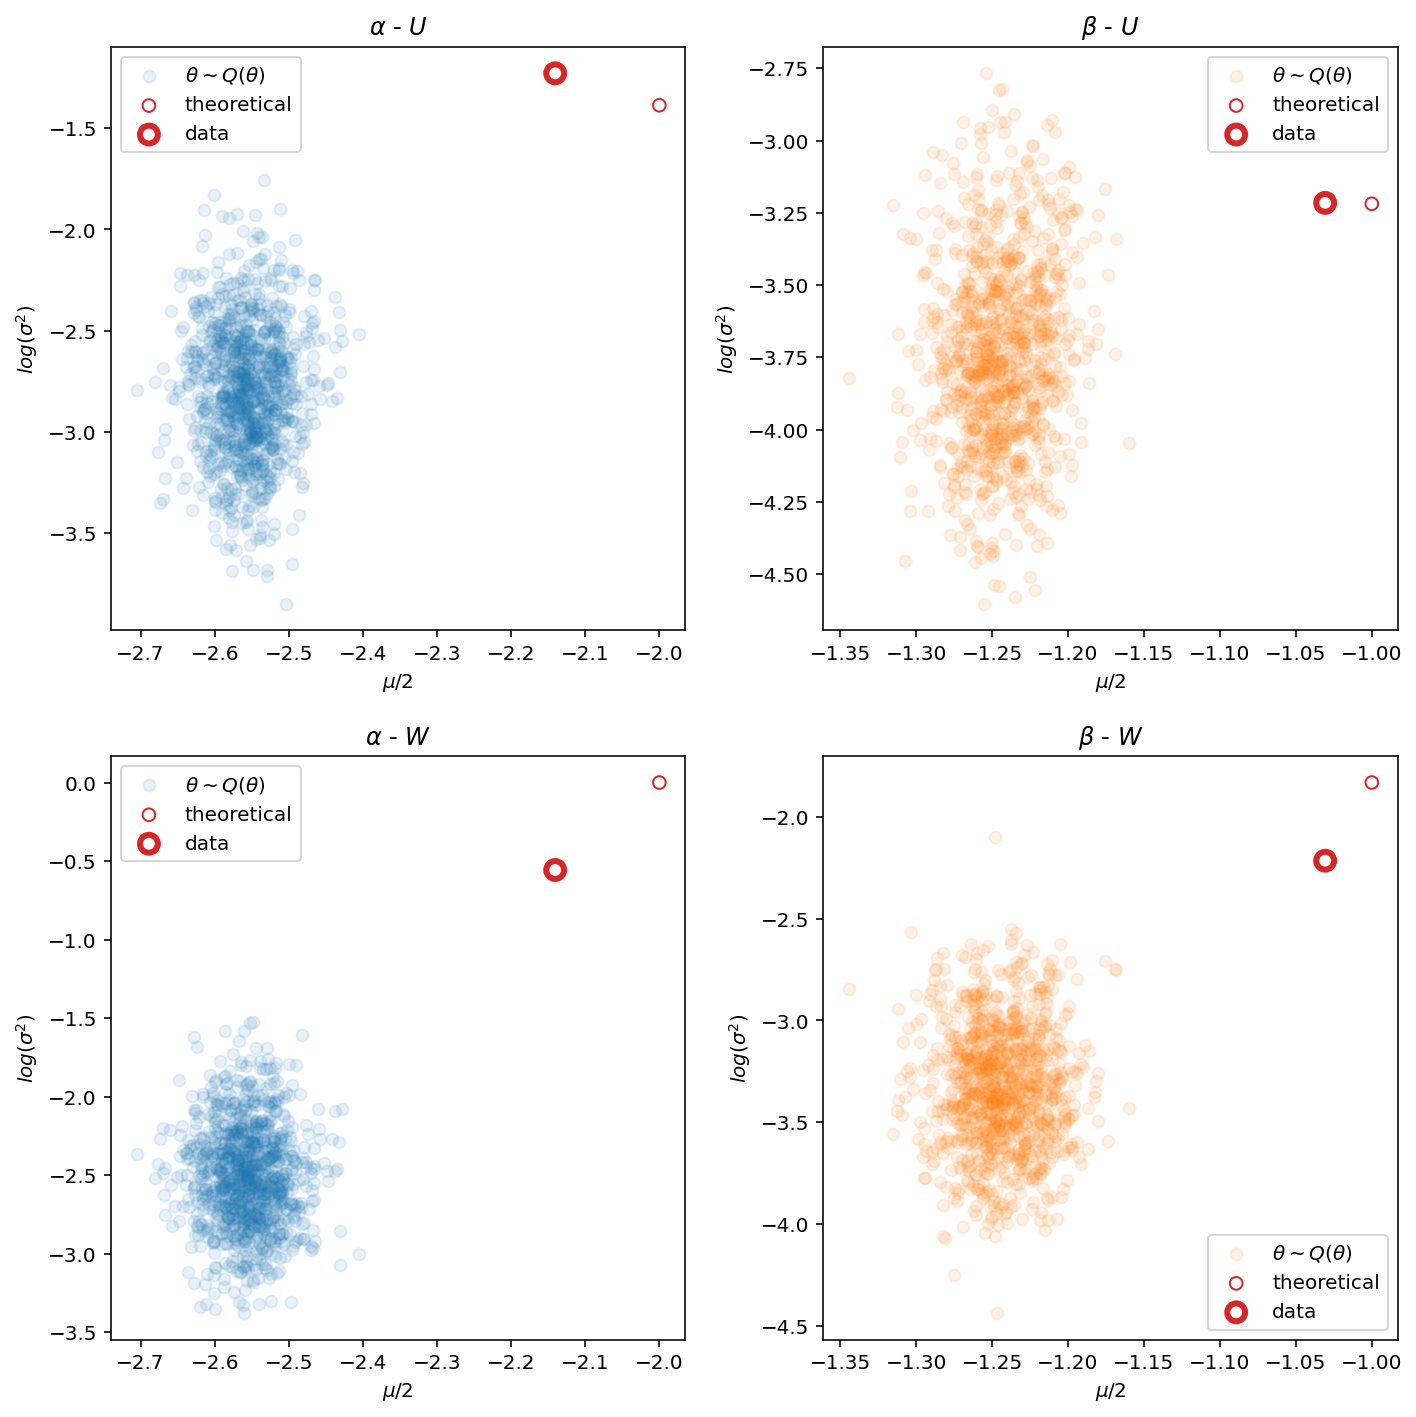

In [49]:
plot_posterior(theta_flow=theta_flow, 
               truth=truth, 
               name='artificial_mini_batch')

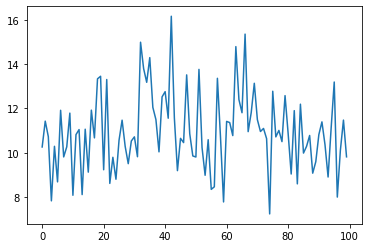

In [39]:
plt.plot(hist_loss[:100])